In [3]:
import os
if not os.path.exists('dataset1'):

  !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
  !unzip -q dataset1.zip
  !rm dataset1.zip
  !pip install -q torch_snippets pytorch_model_summary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from torch_snippets import*
from torchvision.transforms import Compose,ToTensor,Normalize
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# New Section

In [5]:
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [6]:
class SegData(Dataset):
  def __init__(self,split):
  
    self.items = stems(f'dataset1/images_prepped_{split}')
    self.split = split

  def __len__(self):
    return len(self.items)
  
  def __getitem__(self,idx):
    img = read(f'dataset1/images_prepped_{self.split}/{self.items[idx]}.png', 1)
    img = cv2.resize(img,(224,224))
    mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[idx]}.png')
    mask = cv2.resize(mask,(224,224))
    return img,mask
  
  def select(self):return self[randint(len(self))]

  def collate_fn(self,batch):
    imgs,masks = list(zip(*batch))
    imgs = torch.cat([transform(img.copy()/255.)[None] for img in imgs]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks ]).long().to(device)
    return imgs,ce_masks




In [7]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

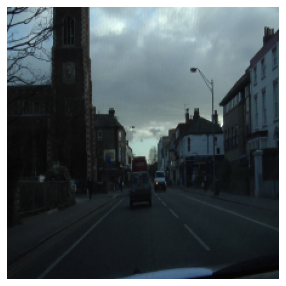

In [8]:
show(trn_ds[10][0])

In [16]:
def conv(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [17]:
def up_conv(in_channels,out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size=2,stride=2),
      nn.ReLU(inplace=True)
  )

In [18]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
  def __init__(self,pretrained=True,out_channels=12):
    super().__init__()
    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)
    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
  
  def forward(self,x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x











In [19]:
loss_fn = nn.CrossEntropyLoss()
def UnetLoss(preds,targets):
  loss = loss_fn(preds,targets)
  acc = (torch.max(preds,1)[1] == targets).float().mean()
  return loss,acc
  

In [20]:
def train_batch(model,data,optimizer,criterion):
  model.train()
  imgs,ce_masks = data
  _masks = model(imgs)
  optimizer.zero_grad()
  loss,acc = criterion(_masks,ce_masks)
  loss.backward()
  optimizer.step()
  return loss.item(),acc.item()

In [21]:
@torch.no_grad()
def validate_batch(model,data,criterion):
  model.eval()
  imgs,masks = data
  _masks = model(imgs)
  loss,acc = criterion(_masks,masks)
  return loss.item(),acc.item()

In [22]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 0.882  val_acc: 0.793  trn_acc: 0.724  trn_loss: 1.254  (24.15s - 458.89s remaining)
EPOCH: 2.000  val_loss: 0.718  val_acc: 0.799  trn_acc: 0.825  trn_loss: 0.707  (41.58s - 374.19s remaining)
EPOCH: 3.000  val_loss: 0.607  val_acc: 0.836  trn_acc: 0.845  trn_loss: 0.579  (59.09s - 334.84s remaining)
EPOCH: 4.000  val_loss: 0.636  val_acc: 0.815  trn_acc: 0.862  trn_loss: 0.504  (77.08s - 308.31s remaining)
EPOCH: 5.000  val_loss: 0.604  val_acc: 0.800  trn_acc: 0.870  trn_loss: 0.463  (95.05s - 285.15s remaining)
EPOCH: 6.000  val_loss: 0.496  val_acc: 0.859  trn_acc: 0.875  trn_loss: 0.441  (112.91s - 263.46s remaining)
EPOCH: 7.000  val_loss: 0.425  val_acc: 0.875  trn_acc: 0.885  trn_loss: 0.399  (130.98s - 243.25s remaining)
EPOCH: 8.000  val_loss: 0.526  val_acc: 0.835  trn_acc: 0.891  trn_loss: 0.378  (149.55s - 224.33s remaining)
EPOCH: 9.000  val_loss: 0.474  val_acc: 0.862  trn_acc: 0.895  trn_loss: 0.367  (167.47s - 204.69s remaining)
EPOCH: 10.000  

100%|██████████| 121/121 [00:00<00:00, 331.00it/s]


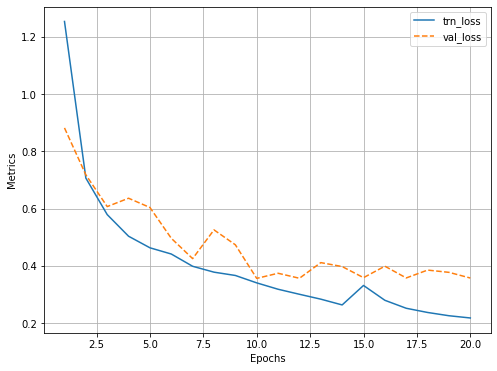

In [24]:
log.plot_epochs(['trn_loss','val_loss'])

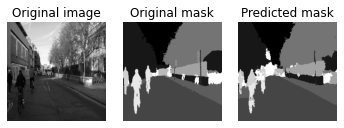

In [25]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])